In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import seaborn as sns
from google.colab import drive
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
#from tensorflow.keras.applications import VGG16
#from tensorflow.keras.applications import InceptionV3
#from tensorflow.keras.applications import ResNet152
#from tensorflow.keras.applications import Xception
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,precision_recall_fscore_support,precision_score,recall_score,f1_score
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler,EarlyStopping

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
img_height, img_width = 512, 512
data_dir = '/content/gdrive/MyDrive/kidney'
class_names = sorted(os.listdir(data_dir))

In [ ]:
# Define your image augmentation parameters
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

images = []
labels = []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
        image = tf.keras.preprocessing.image.img_to_array(image)

        # Apply data augmentation
        image = datagen.random_transform(image)

        image = tf.keras.applications.efficientnet.preprocess_input(image)
        images.append(image)
        labels.append(class_idx)

images = np.array(images)
labels = np.array(labels)


In [ ]:
base_model1 = EfficientNetB0(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model1.output)
efficientnet_model = tf.keras.models.Model(inputs=base_model1.input, outputs=x)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
def evaluate(y_true,y_pred,model):
  accuracy = accuracy_score(y_true,y_pred)
  print(f"Evaluation result for {model}")
  print("****************************")
  print('Classification report')
  print(classification_report(y_true,y_pred))
  true_labels = y_true
  predicted_labels = y_pred
  num_classes = 5
  precision_scores = {}
  recall_scores = {}
  f1_scores = {}
  accuracy_scores = {}
  zero_division = 1
  for class_label in range(num_classes):
      true_class = [1 if label == class_label else 0 for label in true_labels]
      predicted_class = [1 if label == class_label else 0 for label in predicted_labels]

      precision = precision_score(true_class, predicted_class, zero_division=zero_division)
      recall = recall_score(true_class, predicted_class, zero_division=zero_division)
      f1 = f1_score(true_class, predicted_class, zero_division=zero_division)
      acc = accuracy_score(true_class,predicted_class)

      precision_scores[class_label] = precision
      recall_scores[class_label] = recall
      f1_scores[class_label] = f1
      accuracy_scores[class_label] = acc

  for class_label in range(num_classes):
      print(f"Class {class_label}:")
      print(f"Accuracy: {accuracy_scores[class_label]:.2f}")
      print(f"Precision: {precision_scores[class_label]:.2f}")
      print(f"Recall: {recall_scores[class_label]:.2f}")
      print(f"F1 Score: {f1_scores[class_label]:.2f}")

      print("=" * 20)

  macro_precision = sum(precision_scores.values()) / len(precision_scores)
  macro_recall = sum(recall_scores.values()) / len(recall_scores)
  macro_f1 = sum(f1_scores.values()) / len(f1_scores)

  micro_precision = precision_score(true_labels, predicted_labels, average='micro')
  micro_recall = recall_score(true_labels, predicted_labels, average='micro')
  micro_f1 = f1_score(true_labels, predicted_labels, average='micro')

  print("Macro Averages:")
  print(f"Macro Precision: {macro_precision:.2f}")
  print(f"Macro Recall: {macro_recall:.2f}")
  print(f"Macro F1 Score: {macro_f1:.2f}")

  print("Micro Averages:")
  print(f"Micro Precision: {micro_precision:.2f}")
  print(f"Micro Recall: {micro_recall:.2f}")
  print(f"Micro F1 Score: {micro_f1:.2f}")
  print(f'\n\nAccuracy: {accuracy}\n\n')
  comat = confusion_matrix(y_true,y_pred)
  sns.heatmap(comat,annot=True)
  return [accuracy,accuracy_scores,precision_scores,recall_scores,f1_scores]

In [ ]:
def plot_history(history):
  pd.DataFrame(history.history).plot()

In [ ]:
img_eff = efficientnet_model.predict(images)

16/16 [==============================] - 16s 345ms/step


In [ ]:
num_features = img_eff.shape[1]
print("Number of features extracted by ResNet152: ",num_features)
print(img_eff.shape)

Number of features extracted by ResNet152:  1280
(499, 1280)


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(img_eff,labels,test_size=0.2,random_state=42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(128,3,activation='relu',input_shape=(x_train.shape[1],1)),
    tf.keras.layers.MaxPool1D(3),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(64,3,activation='relu'),
    tf.keras.layers.MaxPool1D(3),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(5,activation='softmax')
])

In [ ]:
model1.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_rf = rf.predict(x_test)

Evaluation result for ResNet152 + RandomForest
****************************
Classification report
              precision    recall  f1-score   support

           1       0.96      0.86      0.91        28
           2       0.69      1.00      0.82        18
           3       0.78      0.56      0.65        25
           4       0.77      0.83      0.80        29

    accuracy                           0.80       100
   macro avg       0.80      0.81      0.79       100
weighted avg       0.81      0.80      0.80       100

Class 0:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Class 1:
Accuracy: 0.95
Precision: 0.96
Recall: 0.86
F1 Score: 0.91
Class 2:
Accuracy: 0.92
Precision: 0.69
Recall: 1.00
F1 Score: 0.82
Class 3:
Accuracy: 0.85
Precision: 0.78
Recall: 0.56
F1 Score: 0.65
Class 4:
Accuracy: 0.88
Precision: 0.77
Recall: 0.83
F1 Score: 0.80
Macro Averages:
Macro Precision: 0.84
Macro Recall: 0.85
Macro F1 Score: 0.84
Micro Averages:
Micro Precision: 0.80
Micro Recal

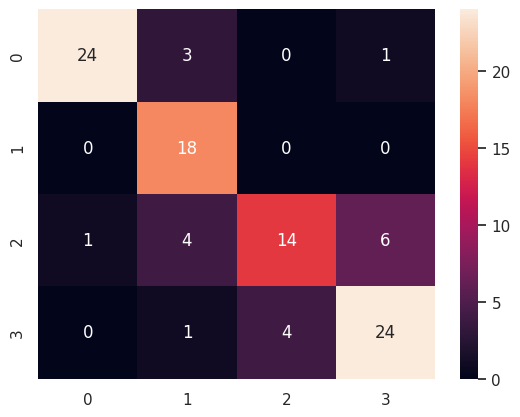

In [ ]:
lst_rf = evaluate(y_test,y_pred_rf,"ResNet152 + RandomForest")
acc_rf = lst_rf[0]
acc_rf_classes = lst_rf[1]
pre_rf = lst_rf[2]
rec_rf = lst_rf[3]
fscore_rf = lst_rf[4]

In [ ]:
train_predictions = rf.predict(x_train)

# Evaluate on training data
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, average='weighted')
train_recall = recall_score(y_train, train_predictions, average='weighted')
train_f1 = f1_score(y_train, train_predictions, average='weighted')

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Training Precision: {train_precision:.2f}")
print(f"Training Recall: {train_recall:.2f}")
print(f"Training F1 Score: {train_f1:.2f}")


Training Accuracy: 1.00
Training Precision: 1.00
Training Recall: 1.00
Training F1 Score: 1.00


In [ ]:
test_predictions = rf.predict(x_test)

# Evaluate on test data
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions, average='weighted')
test_recall = recall_score(y_test, test_predictions, average='weighted')
test_f1 = f1_score(y_test, test_predictions, average='weighted')

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")

Test Accuracy: 0.80
Test Precision: 0.81
Test Recall: 0.80
Test F1 Score: 0.80


In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [ ]:
history = model.fit(x_train,y_train_encoded,validation_data=(x_test,y_test_encoded),epochs=50)

Epoch 1/50
13/13 [==============================] - 4s 25ms/step - loss: 1.6075 - accuracy: 0.2306 - val_loss: 1.4586 - val_accuracy: 0.3000
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 1.3985 - accuracy: 0.3709 - val_loss: 1.2542 - val_accuracy: 0.4700
Epoch 3/50
13/13 [==============================] - 0s 8ms/step - loss: 1.2687 - accuracy: 0.4185 - val_loss: 1.0973 - val_accuracy: 0.5900
Epoch 4/50
13/13 [==============================] - 0s 7ms/step - loss: 1.1585 - accuracy: 0.4386 - val_loss: 1.0023 - val_accuracy: 0.6200
Epoch 5/50
13/13 [==============================] - 0s 8ms/step - loss: 1.0565 - accuracy: 0.5338 - val_loss: 0.9097 - val_accuracy: 0.6300
Epoch 6/50
13/13 [==============================] - 0s 7ms/step - loss: 0.9381 - accuracy: 0.6190 - val_loss: 0.7943 - val_accuracy: 0.6800
Epoch 7/50
13/13 [==============================] - 0s 7ms/step - loss: 0.9195 - accuracy: 0.6190 - val_loss: 0.7713 - val_accuracy: 0.6600
Epoch 8/50
13/13 [=

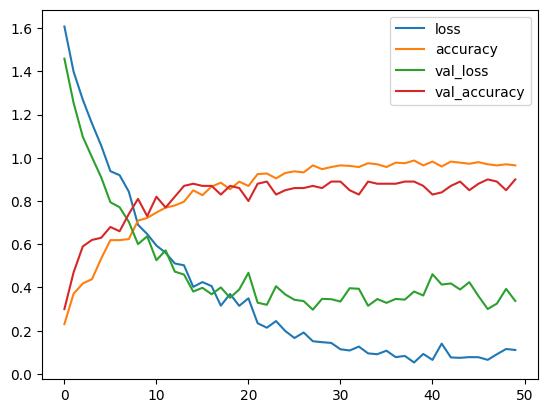

In [ ]:
plot_history(history)

4/4 [==============================] - 0s 2ms/step
Evaluation result for Resnet152+ANN
****************************
Classification report
              precision    recall  f1-score   support

           1       0.96      0.89      0.93        28
           2       0.89      0.94      0.92        18
           3       0.91      0.84      0.87        25
           4       0.84      0.93      0.89        29

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

Class 0:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Class 1:
Accuracy: 0.96
Precision: 0.96
Recall: 0.89
F1 Score: 0.93
Class 2:
Accuracy: 0.97
Precision: 0.89
Recall: 0.94
F1 Score: 0.92
Class 3:
Accuracy: 0.94
Precision: 0.91
Recall: 0.84
F1 Score: 0.87
Class 4:
Accuracy: 0.93
Precision: 0.84
Recall: 0.93
F1 Score: 0.89
Macro Averages:
Macro Precision: 0.92
Macro Recall: 0.92
Macro F1 Score: 0.92
Micro Ave

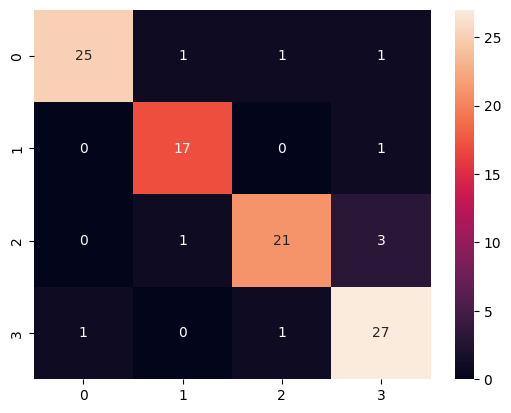

In [ ]:
y_preps1 = model.predict(x_test)
y_preds1 = np.argmax(y_preps1,axis=1)

lst_ann = evaluate(y_test,y_preds1,"Resnet152+ANN")
acc_ann = lst_ann[0]
acc_ann_class = lst_ann[1]
pre_ann = lst_ann[2]
rec_ann = lst_ann[3]
fscore_ann = lst_ann[4]

In [ ]:
history1 = model1.fit(x_train,y_train_encoded,validation_data=(x_test,y_test_encoded),epochs=50)

Epoch 1/50
13/13 [==============================] - 6s 41ms/step - loss: 1.4622 - accuracy: 0.2531 - val_loss: 1.4767 - val_accuracy: 0.1800
Epoch 2/50
13/13 [==============================] - 0s 12ms/step - loss: 1.3479 - accuracy: 0.3534 - val_loss: 1.3089 - val_accuracy: 0.4300
Epoch 3/50
13/13 [==============================] - 0s 11ms/step - loss: 1.2276 - accuracy: 0.4962 - val_loss: 1.2405 - val_accuracy: 0.4300
Epoch 4/50
13/13 [==============================] - 0s 11ms/step - loss: 1.1349 - accuracy: 0.4812 - val_loss: 1.1836 - val_accuracy: 0.4500
Epoch 5/50
13/13 [==============================] - 0s 11ms/step - loss: 0.9833 - accuracy: 0.5639 - val_loss: 0.9480 - val_accuracy: 0.5500
Epoch 6/50
13/13 [==============================] - 0s 12ms/step - loss: 0.8247 - accuracy: 0.6617 - val_loss: 0.7340 - val_accuracy: 0.7500
Epoch 7/50
13/13 [==============================] - 0s 11ms/step - loss: 0.6466 - accuracy: 0.7569 - val_loss: 0.5838 - val_accuracy: 0.7500
Epoch 8/50
13

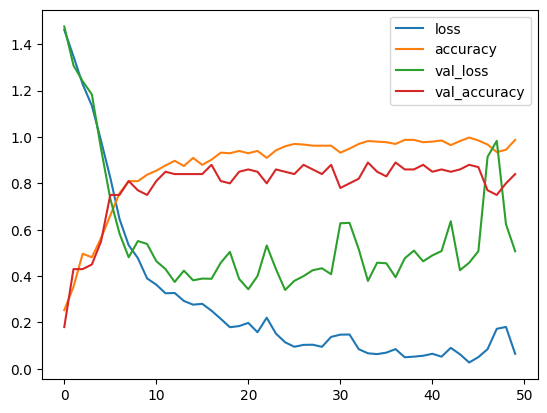

In [ ]:
plot_history(history1)

4/4 [==============================] - 0s 4ms/step
Evaluation result for ResNet152+CNN
****************************
Classification report
              precision    recall  f1-score   support

           1       1.00      0.82      0.90        28
           2       0.62      1.00      0.77        18
           3       0.90      0.72      0.80        25
           4       0.89      0.86      0.88        29

    accuracy                           0.84       100
   macro avg       0.85      0.85      0.84       100
weighted avg       0.88      0.84      0.84       100

Class 0:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Class 1:
Accuracy: 0.95
Precision: 1.00
Recall: 0.82
F1 Score: 0.90
Class 2:
Accuracy: 0.89
Precision: 0.62
Recall: 1.00
F1 Score: 0.77
Class 3:
Accuracy: 0.91
Precision: 0.90
Recall: 0.72
F1 Score: 0.80
Class 4:
Accuracy: 0.93
Precision: 0.89
Recall: 0.86
F1 Score: 0.88
Macro Averages:
Macro Precision: 0.88
Macro Recall: 0.88
Macro F1 Score: 0.87
Micro Ave

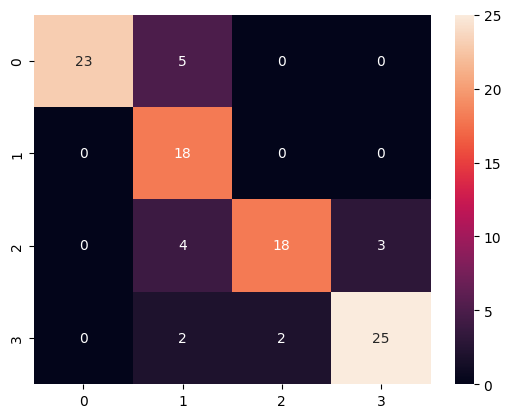

In [ ]:
y_preps2 = model1.predict(x_test)
y_preds2 = np.argmax(y_preps2,axis=1)

lst_cnn = evaluate(y_test,y_preds2,"ResNet152+CNN")
acc_cnn = lst_cnn[0]
acc_cnn_class = lst_cnn[1]
pre_cnn = lst_cnn[2]
rec_cnn = lst_cnn[3]
fscore_cnn = lst_cnn[4]

In [ ]:
rf.fit(img_eff,labels)

RandomForestClassifier(n_estimators=500, random_state=42)

In [ ]:
feature_importances = rf.feature_importances_

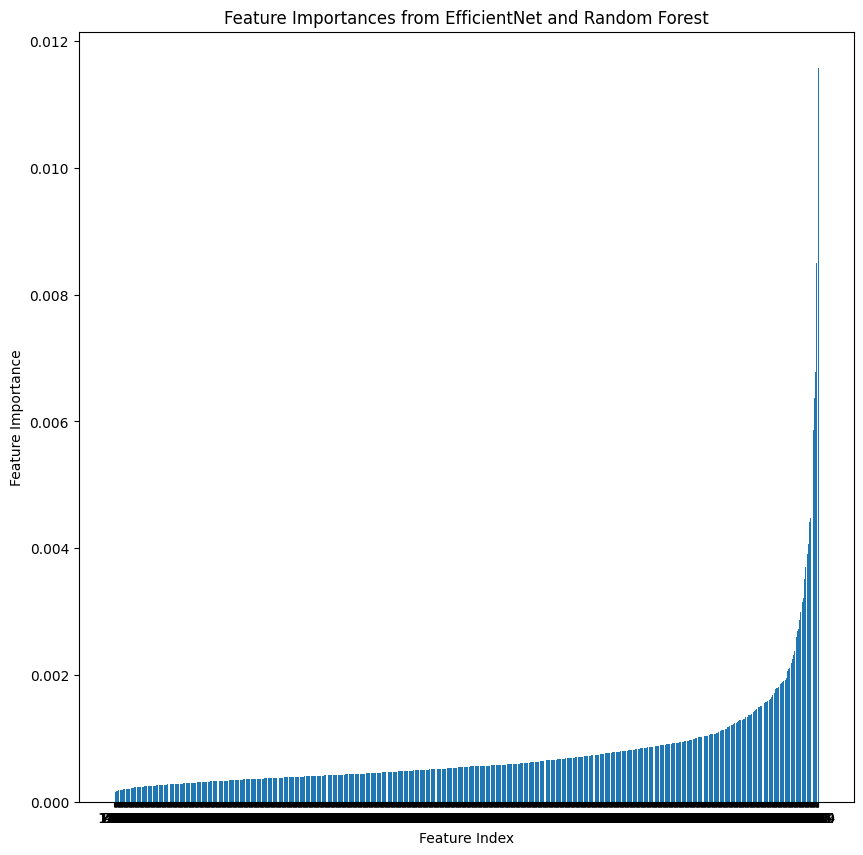

In [ ]:
sorted_indices = feature_importances.argsort()
plt.figure(figsize=(10,10))
plt.bar(range(x.shape[1]), feature_importances[sorted_indices])
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.title("Feature Importances from EfficientNet and Random Forest")
plt.xticks(range(x.shape[1]), sorted_indices)
plt.show()

In [ ]:
num_selected_features =int(0.7*len(feature_importances))
selected_feature_indices = np.argsort(feature_importances)[::-1][:num_selected_features]
selected_features = img_eff[:, selected_feature_indices]

In [ ]:
print("Number ofselected features using feature importance: ", num_selected_features)

Number ofselected features using feature importance:  896


In [ ]:
x_train_fi,x_test_fi,y_train_fi,y_test_fi = train_test_split(selected_features,labels,test_size=0.2,random_state=42)

In [ ]:
rf.fit(x_train_fi,y_train_fi)

RandomForestClassifier(n_estimators=500, random_state=42)

In [ ]:
y_pred_fi_rf = rf.predict(x_test_fi)

Evaluation result for ResNet152 + FeatureImportance + RandomForest
****************************
Classification report
              precision    recall  f1-score   support

           1       0.92      0.82      0.87        28
           2       0.62      1.00      0.77        18
           3       0.83      0.60      0.70        25
           4       0.82      0.79      0.81        29

    accuracy                           0.79       100
   macro avg       0.80      0.80      0.78       100
weighted avg       0.82      0.79      0.79       100

Class 0:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Class 1:
Accuracy: 0.93
Precision: 0.92
Recall: 0.82
F1 Score: 0.87
Class 2:
Accuracy: 0.89
Precision: 0.62
Recall: 1.00
F1 Score: 0.77
Class 3:
Accuracy: 0.87
Precision: 0.83
Recall: 0.60
F1 Score: 0.70
Class 4:
Accuracy: 0.89
Precision: 0.82
Recall: 0.79
F1 Score: 0.81
Macro Averages:
Macro Precision: 0.84
Macro Recall: 0.84
Macro F1 Score: 0.83
Micro Averages:
Micro Precisi

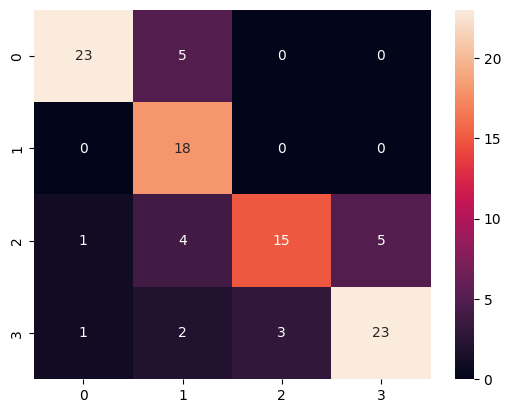

In [ ]:
lst_fi_rf = evaluate(y_test,y_pred_fi_rf,"ResNet152 + FeatureImportance + RandomForest")
acc_fi_rf = lst_fi_rf[0]
acc_fi_rf_class = lst_fi_rf[1]
pre_fi_rf = lst_fi_rf[2]
rec_fi_rf = lst_fi_rf[3]
fscore_fi_rf = lst_fi_rf[4]

In [ ]:
sns.set()
pca = PCA()
pca.fit(img_eff)
explained_variance_ratio = pca.explained_variance_ratio_

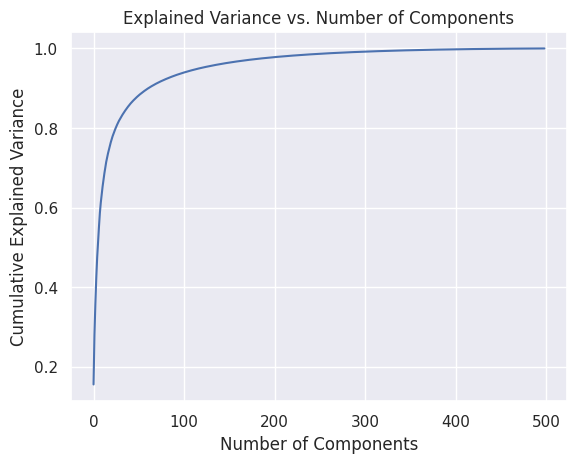

In [ ]:
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

In [ ]:
desired_variance = 0.99
n_components = np.argmax(np.cumsum(explained_variance_ratio) >= desired_variance) + 1
print("Number of components to retain:", n_components)

Number of components to retain: 280


In [ ]:
pca = PCA(n_components=n_components,random_state=42)
X_pca = pca.fit_transform(img_eff)

In [ ]:
x_train_pca,x_test_pca,y_train_pca,y_test_pca = train_test_split(X_pca,labels,test_size=0.2,random_state=42)

In [ ]:
rf.fit(x_train_pca,y_train_pca)

RandomForestClassifier(n_estimators=500, random_state=42)

In [ ]:
y_pred_pca_rf = rf.predict(x_test_pca)

Evaluation result for Efficientnet + PCA + RandomForest
****************************
Classification report
              precision    recall  f1-score   support

           1       1.00      0.54      0.70        28
           2       0.53      0.89      0.67        18
           3       0.80      0.48      0.60        25
           4       0.60      0.83      0.70        29

    accuracy                           0.67       100
   macro avg       0.73      0.68      0.66       100
weighted avg       0.75      0.67      0.67       100

Class 0:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Class 1:
Accuracy: 0.87
Precision: 1.00
Recall: 0.54
F1 Score: 0.70
Class 2:
Accuracy: 0.84
Precision: 0.53
Recall: 0.89
F1 Score: 0.67
Class 3:
Accuracy: 0.84
Precision: 0.80
Recall: 0.48
F1 Score: 0.60
Class 4:
Accuracy: 0.79
Precision: 0.60
Recall: 0.83
F1 Score: 0.70
Macro Averages:
Macro Precision: 0.79
Macro Recall: 0.75
Macro F1 Score: 0.73
Micro Averages:
Micro Precision: 0.67
Mi

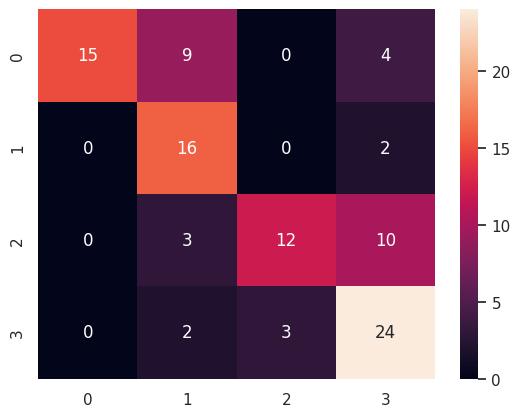

In [ ]:
lst_pca_rf = evaluate(y_test_pca,y_pred_pca_rf,"Efficientnet + PCA + RandomForest")
acc_pca_rf = lst_pca_rf[0]
acc_pca_rf_class = lst_pca_rf[1]
pre_pca_rf = lst_pca_rf[2]
rec_pca_rf = lst_pca_rf[3]
fscore_pca_rf = lst_pca_rf[4]

In [ ]:
y_train_fi_encoded = tf.keras.utils.to_categorical(y_train_fi)
y_test_fi_encoded = tf.keras.utils.to_categorical(y_test_fi)

In [ ]:
dropout_values = [0.2,0.3,0.4]
l2_regularization_strengths = [0.001, 0.01, 0.1]

best_val_accuracy = 0.0
best_dropout = None
best_l2_strength = None
best_weight1 = None

In [ ]:
for dropout in dropout_values:
    for l2_strength in l2_regularization_strengths:
        model_pca = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=x_train_fi.shape[1:]),
            tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_strength)),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_strength)),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_strength)),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(5, activation='softmax')
        ])
        model_pca.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
        tf.random.set_seed(42)
        tf.random.set_seed(42)
        history_pca = model_pca.fit(x_train_fi,y_train_fi_encoded,validation_data=(x_test_fi,y_test_fi_encoded),epochs=100)
        val_loss, val_accuracy = model_pca.evaluate(x_test_fi, y_test_fi_encoded, verbose=0)
        weights = model_pca.get_weights()
        print(f"Dropout: {dropout}, L2 Strength: {l2_strength}, Validation Accuracy: {val_accuracy:.4f}")
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_dropout = dropout
            best_l2_strength = l2_strength
            best_weight1 = weights

print(f"\nBest Dropout: {best_dropout}, Best L2 Strength: {best_l2_strength}, Best Validation Accuracy: {best_val_accuracy:.4f}")

Epoch 1/100
13/13 [==============================] - 2s 23ms/step - loss: 1.6552 - accuracy: 0.3333 - val_loss: 1.4934 - val_accuracy: 0.3200
Epoch 2/100
13/13 [==============================] - 0s 9ms/step - loss: 1.4651 - accuracy: 0.3960 - val_loss: 1.3523 - val_accuracy: 0.5200
Epoch 3/100
13/13 [==============================] - 0s 7ms/step - loss: 1.3469 - accuracy: 0.4762 - val_loss: 1.1638 - val_accuracy: 0.6400
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 1.2029 - accuracy: 0.5338 - val_loss: 1.1010 - val_accuracy: 0.6700
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 1.1628 - accuracy: 0.5388 - val_loss: 1.0801 - val_accuracy: 0.6600
Epoch 6/100
13/13 [==============================] - 0s 7ms/step - loss: 1.0292 - accuracy: 0.6391 - val_loss: 0.9231 - val_accuracy: 0.7800
Epoch 7/100
13/13 [==============================] - 0s 8ms/step - loss: 0.9723 - accuracy: 0.6617 - val_loss: 0.8679 - val_accuracy: 0.7300
Epoch 8/100


In [ ]:
model_fi = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train_fi.shape[1:]),
    tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(best_l2_strength)),
    tf.keras.layers.Dropout(best_dropout),
    tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(best_l2_strength)),
    tf.keras.layers.Dropout(best_dropout),
    tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(best_l2_strength)),
    tf.keras.layers.Dropout(best_dropout),
    tf.keras.layers.Dense(5, activation='softmax')
])
model_fi.set_weights(best_weight1)

In [ ]:
model_fi.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
history_fi = model_fi.fit(x_train_fi,y_train_fi_encoded,validation_data=(x_test_fi,y_test_fi_encoded),epochs=100)

Epoch 1/100
13/13 [==============================] - 2s 23ms/step - loss: 0.2033 - accuracy: 0.9749 - val_loss: 0.3637 - val_accuracy: 0.9100
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 0.1921 - accuracy: 0.9724 - val_loss: 0.4512 - val_accuracy: 0.9300
Epoch 3/100
13/13 [==============================] - 0s 7ms/step - loss: 0.1910 - accuracy: 0.9799 - val_loss: 0.3378 - val_accuracy: 0.9200
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 0.1827 - accuracy: 0.9799 - val_loss: 0.4400 - val_accuracy: 0.9000
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 0.1621 - accuracy: 0.9900 - val_loss: 0.4271 - val_accuracy: 0.9000
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 0.1701 - accuracy: 0.9875 - val_loss: 0.5290 - val_accuracy: 0.8900
Epoch 7/100
13/13 [==============================] - 0s 8ms/step - loss: 0.1671 - accuracy: 0.9825 - val_loss: 0.6853 - val_accuracy: 0.8800
Epoch 8/100


<Axes: >

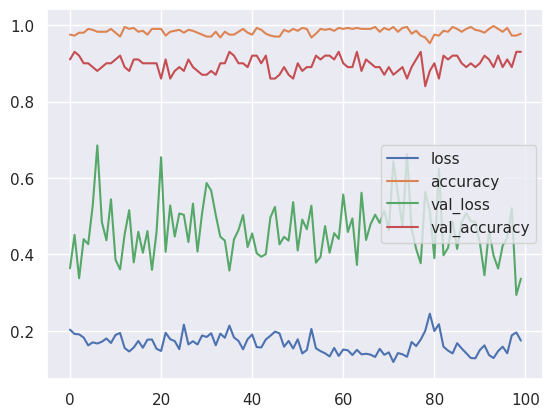

In [ ]:
pd.DataFrame(history_fi.history).plot()

4/4 [==============================] - 0s 3ms/step
Evaluation result for ResNet152+FI+ANN
****************************
Classification report
              precision    recall  f1-score   support

           1       0.96      0.93      0.95        28
           2       0.84      0.89      0.86        18
           3       0.92      0.96      0.94        25
           4       0.96      0.93      0.95        29

    accuracy                           0.93       100
   macro avg       0.92      0.93      0.92       100
weighted avg       0.93      0.93      0.93       100

Class 0:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Class 1:
Accuracy: 0.97
Precision: 0.96
Recall: 0.93
F1 Score: 0.95
Class 2:
Accuracy: 0.95
Precision: 0.84
Recall: 0.89
F1 Score: 0.86
Class 3:
Accuracy: 0.97
Precision: 0.92
Recall: 0.96
F1 Score: 0.94
Class 4:
Accuracy: 0.97
Precision: 0.96
Recall: 0.93
F1 Score: 0.95
Macro Averages:
Macro Precision: 0.94
Macro Recall: 0.94
Macro F1 Score: 0.94
Micro 

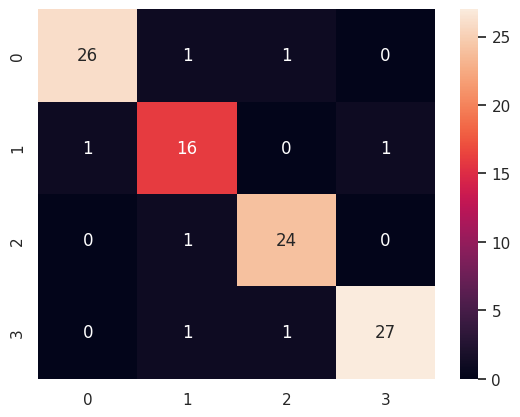

In [ ]:
y_preps3 = model_fi.predict(x_test_fi)
y_preds3 = np.argmax(y_preps3,axis=1)

lst_fi_ann = evaluate(y_test,y_preds3,"ResNet152+FI+ANN")
acc_fi_ann = lst_fi_ann[0]
acc_fi_ann_class = lst_fi_ann[1]
pre_fi_ann = lst_fi_ann[2]
rec_fi_ann = lst_fi_ann[3]
fscore_fi_ann = lst_fi_ann[4]

In [ ]:
y_train_pca_encoded = tf.keras.utils.to_categorical(y_train_pca)
y_test_pca_encoded = tf.keras.utils.to_categorical(y_test_pca)

In [ ]:
dropout_values = [0.2,0.3,0.4]
l2_regularization_strengths = [0.001, 0.01, 0.1]

best_val_accuracy = 0.0
best_dropout = None
best_l2_strength = None
best_weight = None

In [ ]:
for dropout in dropout_values:
    for l2_strength in l2_regularization_strengths:
        model_pca = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=x_train_pca.shape[1:]),
            tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_strength)),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_strength)),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_strength)),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(5, activation='softmax')
        ])
        model_pca.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
        history_pca = model_pca.fit(x_train_pca,y_train_pca_encoded,validation_data=(x_test_pca,y_test_pca_encoded),epochs=100)
        val_loss, val_accuracy = model_pca.evaluate(x_test_pca, y_test_pca_encoded, verbose=0)
        weight = model_pca.get_weights()
        print(f"Dropout: {dropout}, L2 Strength: {l2_strength}, Validation Accuracy: {val_accuracy:.4f}")
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_dropout = dropout
            best_l2_strength = l2_strength
            best_weight = weight

print(f"\nBest Dropout: {best_dropout}, Best L2 Strength: {best_l2_strength}, Best Validation Accuracy: {best_val_accuracy:.4f}")

Epoch 1/100
13/13 [==============================] - 2s 23ms/step - loss: 1.7665 - accuracy: 0.2707 - val_loss: 1.7269 - val_accuracy: 0.3400
Epoch 2/100
13/13 [==============================] - 0s 9ms/step - loss: 1.6806 - accuracy: 0.3409 - val_loss: 1.6562 - val_accuracy: 0.3400
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 1.5655 - accuracy: 0.4060 - val_loss: 1.5740 - val_accuracy: 0.3400
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 1.4845 - accuracy: 0.4135 - val_loss: 1.4873 - val_accuracy: 0.4000
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 1.3853 - accuracy: 0.4937 - val_loss: 1.3789 - val_accuracy: 0.4900
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 1.2589 - accuracy: 0.5915 - val_loss: 1.2647 - val_accuracy: 0.5900
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 1.1619 - accuracy: 0.6441 - val_loss: 1.1454 - val_accuracy: 0.7400
Epoch 8/100


In [ ]:
model_pca = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train_pca.shape[1:]),
    tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(best_l2_strength)),
    tf.keras.layers.Dropout(best_dropout),
    tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(best_l2_strength)),
    tf.keras.layers.Dropout(best_dropout),
    tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(best_l2_strength)),
    tf.keras.layers.Dropout(best_dropout),
    tf.keras.layers.Dense(5, activation='softmax')
])
model_pca.set_weights(best_weight)

In [ ]:
model_pca.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
history_pca = model_pca.fit(x_train_pca,y_train_pca_encoded,validation_data=(x_test_pca,y_test_pca_encoded),epochs=100)

Epoch 1/100
13/13 [==============================] - 2s 23ms/step - loss: 0.1483 - accuracy: 0.9925 - val_loss: 0.3924 - val_accuracy: 0.9200
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 0.1533 - accuracy: 0.9950 - val_loss: 0.3994 - val_accuracy: 0.9100
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.1502 - accuracy: 0.9875 - val_loss: 0.3811 - val_accuracy: 0.9300
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 0.1544 - accuracy: 0.9850 - val_loss: 0.3800 - val_accuracy: 0.9300
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 0.1279 - accuracy: 1.0000 - val_loss: 0.3913 - val_accuracy: 0.9200
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 0.1547 - accuracy: 0.9900 - val_loss: 0.3868 - val_accuracy: 0.9100
Epoch 7/100
13/13 [==============================] - 0s 11ms/step - loss: 0.1334 - accuracy: 0.9950 - val_loss: 0.3886 - val_accuracy: 0.9200
Epoch 8/100

<Axes: >

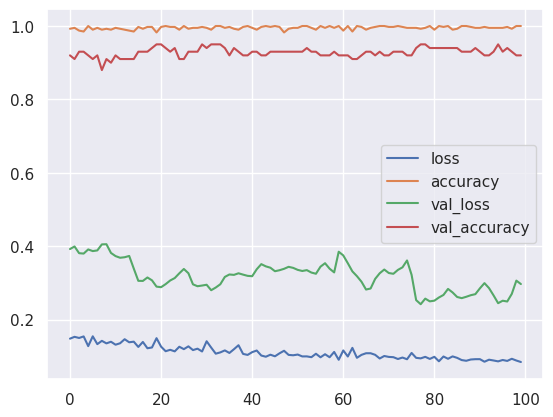

In [ ]:
pd.DataFrame(history_pca.history).plot()

4/4 [==============================] - 0s 3ms/step
Evaluation result for ResNet+PCA+ANN
****************************
Classification report
              precision    recall  f1-score   support

           1       1.00      0.89      0.94        28
           2       0.75      1.00      0.86        18
           3       0.95      0.84      0.89        25
           4       0.97      0.97      0.97        29

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.91       100
weighted avg       0.93      0.92      0.92       100

Class 0:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Class 1:
Accuracy: 0.97
Precision: 1.00
Recall: 0.89
F1 Score: 0.94
Class 2:
Accuracy: 0.94
Precision: 0.75
Recall: 1.00
F1 Score: 0.86
Class 3:
Accuracy: 0.95
Precision: 0.95
Recall: 0.84
F1 Score: 0.89
Class 4:
Accuracy: 0.98
Precision: 0.97
Recall: 0.97
F1 Score: 0.97
Macro Averages:
Macro Precision: 0.93
Macro Recall: 0.94
Macro F1 Score: 0.93
Micro Av

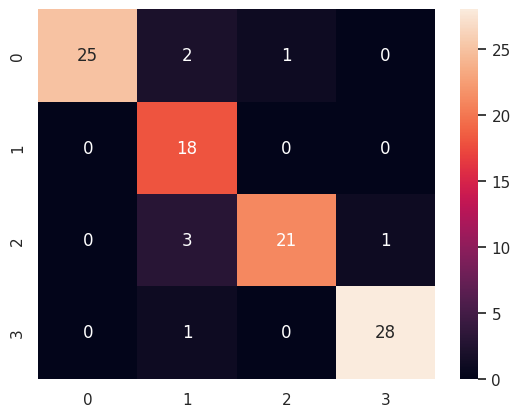

In [ ]:
y_preps4 = model_pca.predict(x_test_pca)
y_preds4 = np.argmax(y_preps4,axis=1)

lst_pca_ann = evaluate(y_test,y_preds4,"ResNet+PCA+ANN")
acc_pca_ann = lst_pca_ann[0]
acc_pca_ann_class = lst_pca_ann[1]
pre_pca_ann = lst_pca_ann[2]
rec_pca_ann = lst_pca_ann[3]
fscore_pca_ann = lst_pca_ann[4]

In [ ]:
precision = list(pre_rf.values())
recall = list(rec_rf.values())
classes = ['Mild','Moderate','No DR','PDR', 'Severe']

In [ ]:
study1 = pd.DataFrame()
study1['Classes'] = classes
study1['Precision'] = precision
study1['Recall'] = recall
study1

,Classes,Precision,Recall
0,Mild,1.000000,1.000000
1,Moderate,0.960000,0.857143
2,No DR,0.692308,1.000000
3,PDR,0.777778,0.560000
4,Severe,0.774194,0.827586


In [ ]:
study1.to_csv('Study1_effnet.csv',index=False)

In [ ]:
models = ['Eff+RF','Eff+ANN']
acc = [acc_pca_rf,acc_pca_ann]

In [ ]:

study2 = pd.DataFrame()
study2['Models'] = models
study2['Accuracy'] = acc
study2

,Models,Accuracy
0,Eff+RF,0.67
1,Eff+ANN,0.92


In [ ]:
study2.to_csv('Study2_effnet.csv',index=False)

In [ ]:
models = ['Eff+RF','Eff+ANN']
acc = [acc_fi_rf,acc_fi_ann]

In [ ]:
study3 = pd.DataFrame()
study3['Models'] = models
study3['Accuracy'] = acc
study3

,Models,Accuracy
0,Eff+RF,0.79
1,Eff+ANN,0.93


In [ ]:
study3.to_csv('Study3_effnet.csv',index=False)

In [ ]:
models = ['Eff+RF','Eff+PCA+RF','Eff+FI+RF','Eff+ANN','Eff+PCA+ANN','Eff+FI+ANN']
acc = [acc_rf,acc_pca_rf,acc_fi_rf,acc_ann,acc_pca_ann,acc_fi_ann]

In [ ]:
study4 = pd.DataFrame()
study4['Models'] = models
study4['Accuracy'] = acc
study4

,Models,Accuracy
0,Eff+RF,0.80
1,Eff+PCA+RF,0.67
2,Eff+FI+RF,0.79
3,Eff+ANN,0.90
4,Eff+PCA+ANN,0.92
5,Eff+FI+ANN,0.93


In [ ]:
study4.to_csv('Study4_effnet.csv',index=False)